# FRETBursts - 8-spot smFRET burst analysis

*This notebook is part of a [tutorial series](https://github.com/tritemio/FRETBursts_notebooks) for the [FRETBursts](http://tritemio.github.io/FRETBursts/) burst analysis software.*

> For a step-by-step introduction to FRETBursts usage please refer to 
> [us-ALEX smFRET burst analysis](FRETBursts - us-ALEX smFRET burst analysis.ipynb).
>
> In this notebook we present a typical [FRETBursts](http://tritemio.github.io/FRETBursts/)
> workflow for **multi-spot smFRET burst analysis**. 
> Briefly, we show how to perform background estimation, burst search, burst selection, 
> FRET histograms, and FRET efficiency fit using different methods. 

## Loading the software

In [1]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.5.5).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1101/039198 

--------------------------------------------------------------

In [2]:
sns = init_notebook()

In [3]:
import lmfit; lmfit.__version__

'0.9.3'

In [4]:
import phconvert; phconvert.__version__

'0.6.9'

# Downloading the sample data file

The complete example dataset can be downloaded 
from [here](http://dx.doi.org/10.6084/m9.figshare.1019906).

Here we download an 8-spot smFRET measurement file using 
the `download_file` in FRETBursts: 

In [5]:
url = 'http://files.figshare.com/2182604/12d_New_30p_320mW_steer_3.hdf5'

In [6]:
download_file(url, save_dir='./data')

URL:  http://files.figshare.com/2182604/12d_New_30p_320mW_steer_3.hdf5
File: 12d_New_30p_320mW_steer_3.hdf5
 
File already on disk: /Users/anto/src/FRETBursts/notebooks/data/12d_New_30p_320mW_steer_3.hdf5 
Delete it to re-download.


# Selecting a data file

In [7]:
filename = "./data/12d_New_30p_320mW_steer_3.hdf5"

In [8]:
import os
assert os.path.exists(filename)

## Data load and Burst search

Load and process the data:

In [9]:
d = loader.photon_hdf5(filename)

For convenience we can set the correction coefficients right away 
so that they will be used in the subsequent analysis. 
The correction coefficients are: 

* leakage or bleed-through: `leakage`
* direct excitation: `dir_ex` (ALEX-only)
* gamma-factor `gamma`

The direct excitation cannot be applied to non-ALEX (single-laser) 
smFRET measurements (like the current one).

In [10]:
d.leakage = 0.038
d.gamma = 0.43

> **NOTE:** at any later moment, after burst search, a simple 
> reassignment of these coefficient will update the burst data 
> with the new correction values.

Compute background and burst search:

In [11]:
d.calc_bg(bg.exp_fit, time_s=30, tail_min_us='auto', F_bg=1.7)
d.burst_search(L=10, m=10, F=7)

 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


Perform a background plot as a function of the channel:

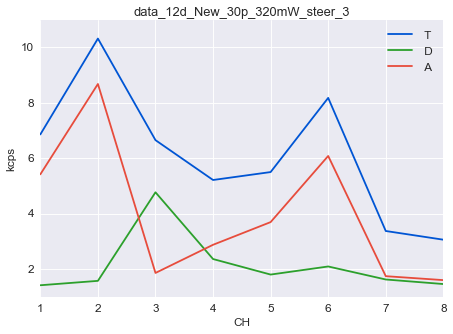

In [12]:
mch_plot_bg(d)

Let's take a look at the photon waiting times histograms and at the fitted background rates:

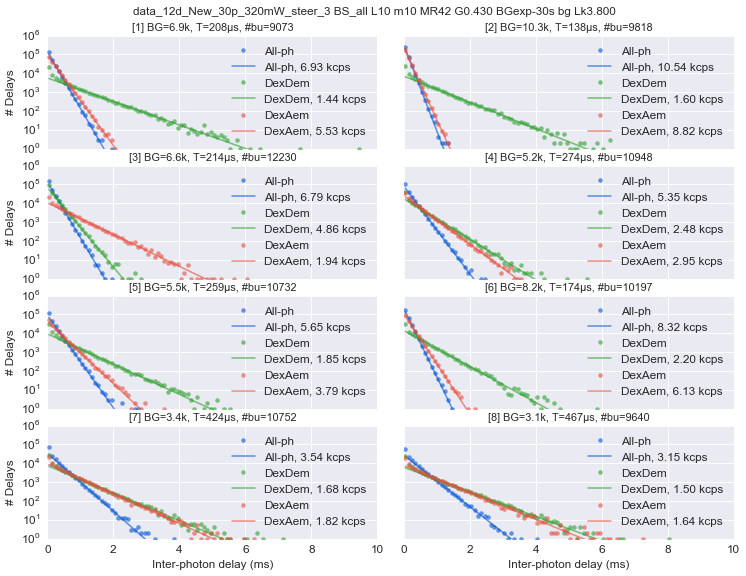

In [13]:
dplot(d, hist_bg);

Using `dplot` exactly in the same way as for the single-spot 
data has now generated 8 subplots, one for each channel.

Let's plot a timetrace for the background to see is there 
are significant variations during the measurement:

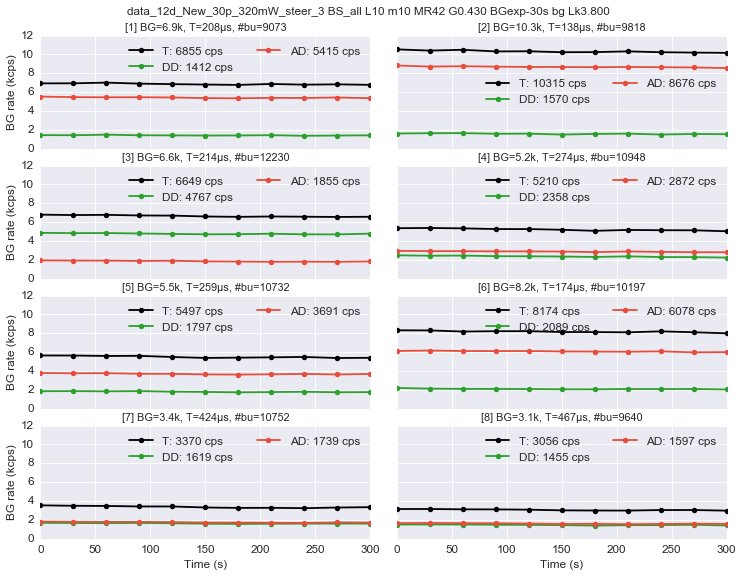

In [14]:
dplot(d, timetrace_bg);

We can look at the timetrace of the photon stream (binning):

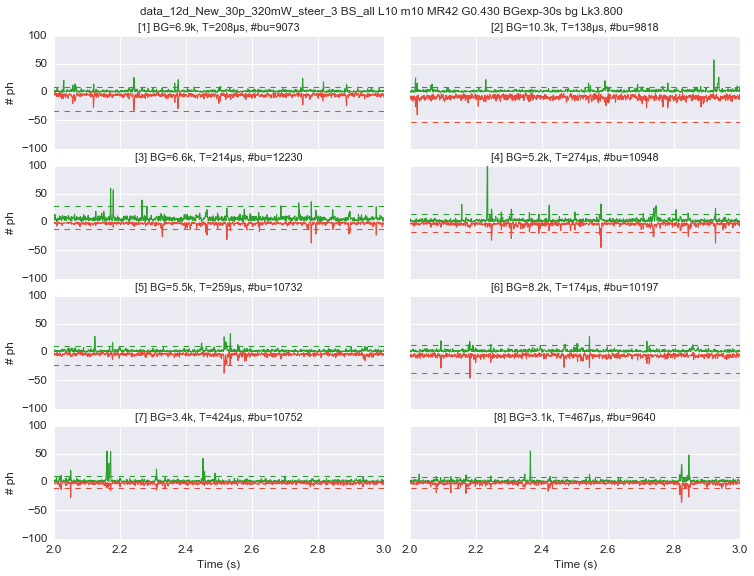

In [15]:
dplot(d, timetrace)
xlim(2, 3); ylim(-100, 100);

We can also open the same plot in an interactive window that allows scrolling (uncomment the following lines):

In [16]:
#%matplotlib qt

In [17]:
#dplot(d, timetrace, scroll=True);

In [18]:
#ylim(-100, 100)

In [19]:
#%matplotlib inline

## Burst selection and FRET

### Selecting bursts by burst size (`select_bursts.size`)

In [20]:
gamma = d.gamma
gamma

array(0.43)

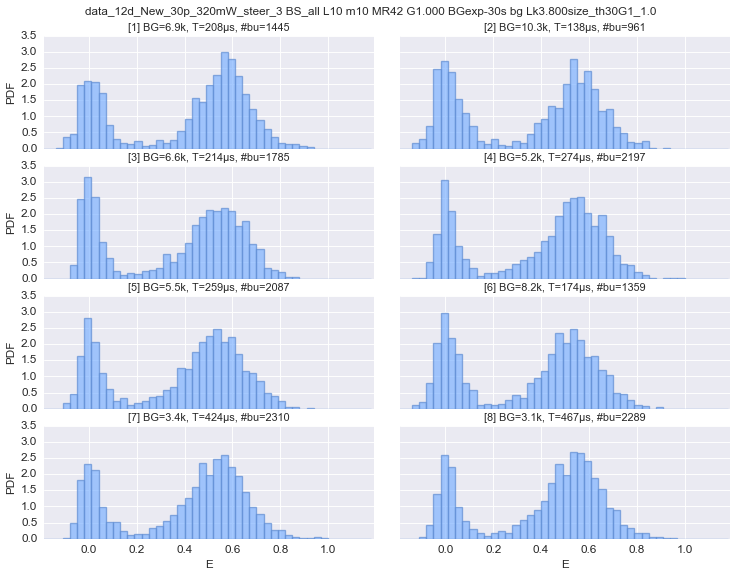

In [21]:
d.gamma = 1
ds = d.select_bursts(select_bursts.size, th1=30, gamma1=1)
dplot(ds, hist_fret);

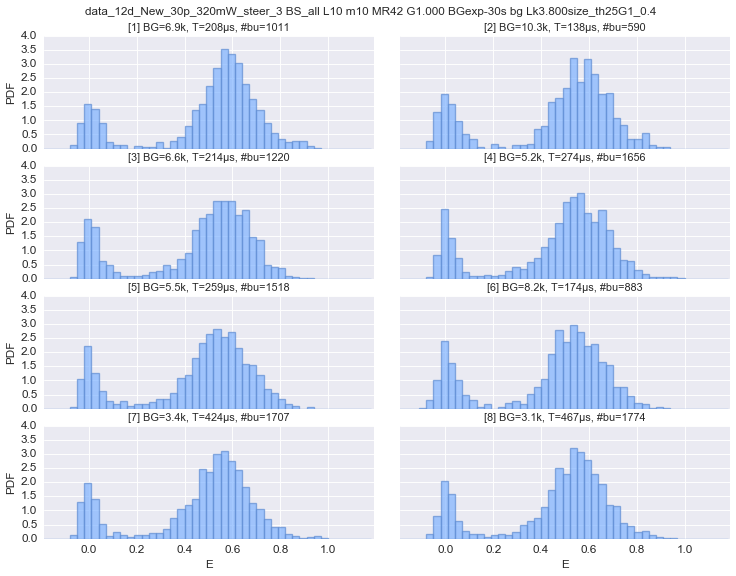

In [22]:
ds = d.select_bursts(select_bursts.size, th1=25, gamma1=gamma)
dplot(ds, hist_fret);

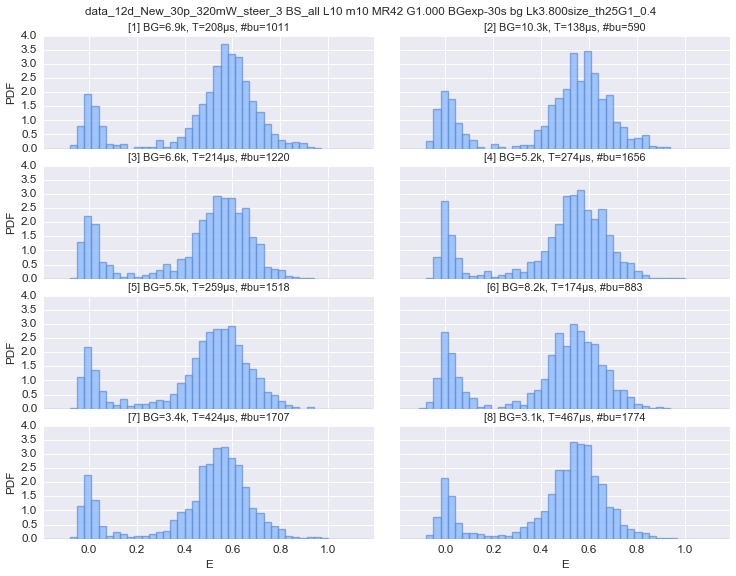

In [23]:
ds = d.select_bursts(select_bursts.size, th1=25, gamma1=gamma)
dplot(ds, hist_fret, weights='size', gamma=gamma);

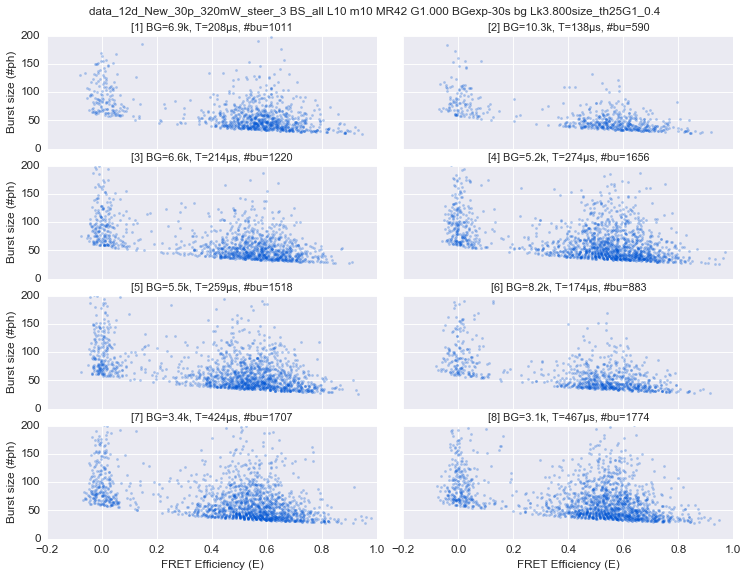

In [24]:
dplot(ds, scatter_fret_nd_na); ylim(0,200);

## FRET Fitting

### 2-Gaussian mixture

Let's fit the $E$ histogram with a 2-Gaussians model:

In [25]:
ds.gamma = 1.
bext.bursts_fitter(ds, weights=None)
ds.E_fitter.fit_histogram(mfit.factory_two_gaussians(), verbose=False)

The fitted parameters are stored in a pandas DataFrame:

In [26]:
ds.E_fitter.params

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma
0,0.158194,0.00936251,0.0389312,0.804081,0.583262,0.0977268
1,0.204439,0.00666433,0.0433187,0.779328,0.574901,0.106507
2,0.190307,0.00405689,0.0345415,0.787448,0.566611,0.111947
3,0.164955,0.00213608,0.0278033,0.802854,0.563049,0.114425
4,0.156925,-0.000268342,0.0294501,0.812289,0.551628,0.11868
5,0.206435,0.00678661,0.0383694,0.773952,0.549137,0.110163
6,0.16393,-0.00129558,0.0328298,0.804734,0.555753,0.109979
7,0.161602,0.00548505,0.0315513,0.799597,0.554737,0.107371


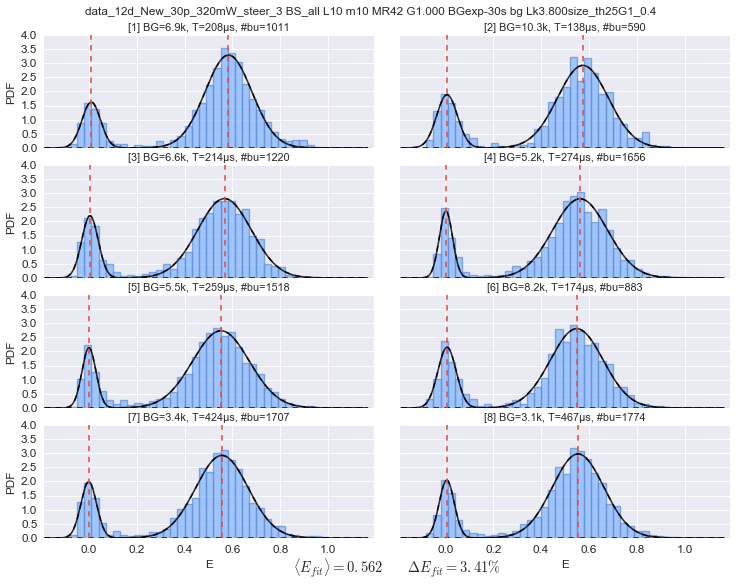

In [27]:
dplot(ds, hist_fret, weights=None, show_model=True,
      show_fit_stats=True, fit_from='p2_center');

### Weighted Expectation Maximization

The [expectation maximization](http://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) 
(EM) method is particularly suited to resolve population 
mixtures. Note that the EM algorithm does not fit the histogram 
but the $E$ distribution with no binning.

FRETBursts include a weighted version of the EM algorithm that 
can take into account the burst size.
The algorithm and benchmarks with the 2-Gaussian histogram fit 
are reported [here](http://nbviewer.ipython.org/github/tritemio/notebooks/blob/master/Mixture_Model_Fitting.ipynb).

You can find the EM algorithm in `fretbursts/fit/gaussian_fit.py` or typing:

`bl.two_gaussian_fit_EM??`


In [28]:
# bl.two_gaussian_fit_EM??

In [29]:
EM_results = ds.fit_E_two_gauss_EM(weights=None, gamma=1.)
EM_results

array([ 0.58655155,  0.57814354,  0.55778843,  0.55654601,  0.54440284,
        0.55141229,  0.5522608 ,  0.55112078])

The fitted parameters for each channel are stored in the `fit_E_res` attribute:

In [30]:
ds.fit_E_name, ds.fit_E_res

('two_gaussian_fit_EM',
 array([[ 0.01639441,  0.04133455,  0.58655155,  0.11385675,  0.16092585],
        [ 0.01575277,  0.04417727,  0.57814354,  0.11338378,  0.20831781],
        [ 0.01439624,  0.03993718,  0.55778843,  0.11964061,  0.19968835],
        [ 0.01000033,  0.03242441,  0.55654601,  0.1275605 ,  0.1743351 ],
        [ 0.00947759,  0.03389794,  0.54440284,  0.1314326 ,  0.16584853],
        [ 0.01591813,  0.04486999,  0.55141229,  0.11501298,  0.21803168],
        [ 0.00672047,  0.03691092,  0.5522608 ,  0.12443467,  0.16765869],
        [ 0.01339861,  0.03935058,  0.55112078,  0.1216904 ,  0.17210592]]))

The model function is stored in:

In [31]:
ds.fit_E_model

<function fretbursts.fit.gaussian_fitting.two_gauss_mix_pdf>

Let's plot the histogram and the model with parameters from the EM fit:

E mean: 55.98%   E delta: 4.21%


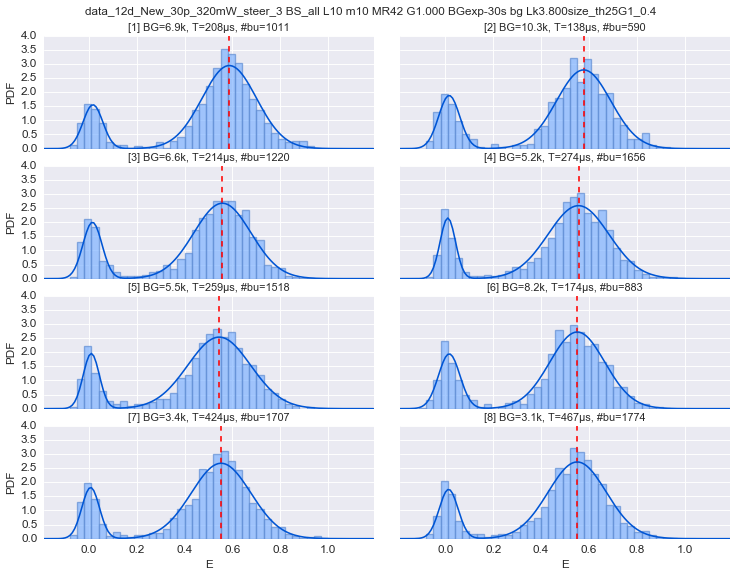

In [32]:
AX = dplot(ds, hist_fret, weights=None)

x = np.r_[-0.2: 1.2 : 0.01]
for ich, (ax, E_fit) in enumerate(zip(AX.ravel(), EM_results)):
    ax.axvline(E_fit, ls='--', color='r')
    ax.plot(x, ds.fit_E_model(x, ds.fit_E_res[ich]))

print('E mean: %.2f%%   E delta: %.2f%%' %\
      (EM_results.mean()*100, (EM_results.max() - EM_results.min())*100))

## Comparing 2-Gaussian and EM fit

To quickly compare the 2-Gaussians with the EM fit we convert the EM fit results in a DataFrame:

In [33]:
import pandas as pd

In [34]:
EM_results = pd.DataFrame(ds.fit_E_res, columns=['p1_center', 'p1_sigma', 'p2_center', 'p2_sigma', 'p1_amplitude'])
EM_results * 100

,p1_center,p1_sigma,p2_center,p2_sigma,p1_amplitude
0,1.639441,4.133455,58.655155,11.385675,16.092585
1,1.575277,4.417727,57.814354,11.338378,20.831781
2,1.439624,3.993718,55.778843,11.964061,19.968835
3,1.000033,3.242441,55.654601,12.756050,17.433510
4,0.947759,3.389794,54.440284,13.143260,16.584853
5,1.591813,4.486999,55.141229,11.501298,21.803168
6,0.672047,3.691092,55.226080,12.443467,16.765869
7,1.339861,3.935058,55.112078,12.169040,17.210592


In [35]:
ds.E_fitter.params * 100

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma
0,15.8194,0.936251,3.89312,80.4081,58.3262,9.77268
1,20.4439,0.666433,4.33187,77.9328,57.4901,10.6507
2,19.0307,0.405689,3.45415,78.7448,56.6611,11.1947
3,16.4955,0.213608,2.78033,80.2854,56.3049,11.4425
4,15.6925,-0.0268342,2.94501,81.2289,55.1628,11.868
5,20.6435,0.678661,3.83694,77.3952,54.9137,11.0163
6,16.393,-0.129558,3.28298,80.4734,55.5753,10.9979
7,16.1602,0.548505,3.15513,79.9597,55.4737,10.7371


And we compute the difference between the two sets of parameters:

In [36]:
(ds.E_fitter.params - EM_results) * 100

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma
0,-0.27317,-0.70319,-0.240334,NaN,-0.328923,-1.61299
1,-0.387927,-0.908844,-0.0858594,NaN,-0.324299,-0.687716
2,-0.938152,-1.03393,-0.539566,NaN,0.882228,-0.769396
3,-0.937981,-0.786426,-0.462107,NaN,0.650278,-1.31354
4,-0.892314,-0.974593,-0.444789,NaN,0.722529,-1.27529
5,-1.15962,-0.913152,-0.650055,NaN,-0.227503,-0.485008
6,-0.372913,-0.801605,-0.40811,NaN,0.349243,-1.44558
7,-1.05043,-0.791357,-0.779927,NaN,0.361586,-1.43195


> **NOTE:** The EM method follows more the "asymmetry" of the 
> peaks because the center is a weighted mean of the bursts. 
> On the contrary the 2-Gaussians histogram fit tends to follows 
> more the peak position an less the "asymmetric" tails.  